##Variability Metrics

These variabilty metrics were developed as a first attempt to understand LSST performance for discovering and characterising periodic variables. They are available in the [sims_maf_contrib](https://github.com/LSST-nonproject/sims_maf_contrib) github repo, in [varMetrics.py](https://github.com/LSST-nonproject/sims_maf_contrib/blob/master/mafContrib/varMetrics.py). 

One metric (PhaseGaps) looks at the gaps in phase coverage for a set of observations. At each point in the sky (if we use a healpix slicer), a range of periods and the times of the visits are converted to phase values: then the largest gap in these phases is calculated. The metric calculates the max gap for a range of periods at each point; thus it also provides a few reduce functions to convert this to the period with the largest gap (at each point in the sky) and the value of the largest gap in phase coverage (at each point in the sky). We can also read the metric values back into python and generate plots of phase gaps vs. period, including the data for all points.

The second metric (PeriodDeviation) generates a light curve (representing the variability of the source as a simple sine curve but neglecting photometric errors) with user-settable range of periods, then attempts to recover the period using a simple lomb-scargle calculation. Changing the period fitting routine would doubtless improve the period recovery.  Again, this should be paired with a healpix slicer to evaluate sets of visits which correspond to the same spot on the sky, and again each point is sampled at a range of different periods so the metric provides reduce methods and we can also read back in the results to evaluate true period vs. fit period across the entire sky. 

(this notebook requires sims_maf version >= 1.0)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Import MAF modules.
import lsst.sims.maf.db as db
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
from lsst.sims.maf.metricBundles import MetricBundle, MetricBundleGroup
# Import the contributed metrics and stackers 
import mafContrib

Connect to the opsim database and set up some metadata.

In [2]:
runName = 'enigma_1189'
dbAddress = 'sqlite:///' + runName + '_sqlite.db'
opsdb = db.OpsimDatabase(dbAddress)
outDir = 'variability_test'

Set up the metrics and slicer. 

In [3]:
phaseMetric = mafContrib.PhaseGapMetric(nPeriods=20, periodMin=0.2, periodMax=3.5)
periodMetric = mafContrib.PeriodDeviationMetric(nPeriods=2, periodMin=2, periodMax=3.5)
phaseslicer = slicers.HealpixSlicer(nside=64, lonCol='ditheredRA', latCol='ditheredDec')
periodslicer = slicers.HealpixSlicer(nside=32, lonCol='ditheredRA', latCol='ditheredDec')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


In [4]:
summaryMetrics = [metrics.MinMetric(), metrics.MaxMetric(), metrics.MeanMetric()]

In [5]:
sqlconstraint = 'night<365 and (filter="r" or filter="i")'
phaseBundle = MetricBundle(phaseMetric, phaseslicer, sqlconstraint=sqlconstraint, 
                           runName=runName, summaryMetrics=summaryMetrics)
periodBundle = MetricBundle(periodMetric, periodslicer, sqlconstraint=sqlconstraint, 
                            runName=runName, summaryMetrics=summaryMetrics)

In [6]:
bdict = {'Phase':phaseBundle, 'Period':periodBundle}

In [7]:
resultsDb = db.ResultsDb(outDir=outDir)
bgroup = MetricBundleGroup(bdict, opsdb, outDir=outDir, resultsDb=resultsDb)

In [8]:
bgroup.runAll()

Querying database with constraint night<365 and (filter="r" or filter="i")
Found 84922 visits
Running:  ['Phase']
Completed metric generation.
Running:  ['Period']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


/Users/lynnej/anaconda/lib/python2.7/site-packages/sqlalchemy/sql/elements.py:3738: SAWarning: Textual SQL expression 'night<365 and (filter="r"...' should be explicitly declared as text('night<365 and (filter="r"...') (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})


Plotting.
monopole: 1.91613  dipole: lon: 119.556, lat: -82.952, amp: 0.0517194
monopole: 0.33615  dipole: lon: -161.014, lat: 43.052, amp: 0.143391
monopole: 0.546249  dipole: lon: -161.216, lat: 45.0019, amp: 0.204637

Cannot plot object metric values with this plotter.
Cannot plot object metric values with this plotter.
Cannot plot object metric values with this plotter.
Optimal bin calculation tried to make 441 bins, returning 200



monopole: 0.0921648  dipole: lon: 44.0286, lat: 57.5174, amp: 0.0486745
monopole: -0.0640762  dipole: lon: 31.9582, lat: -11.1708, amp: 0.0689994
monopole: 2.69567  dipole: lon: -8.41883, lat: -9.40168, amp: 0.0286165
Plotting complete.


Cannot plot object metric values with this plotter.
Cannot plot object metric values with this plotter.
Cannot plot object metric values with this plotter.


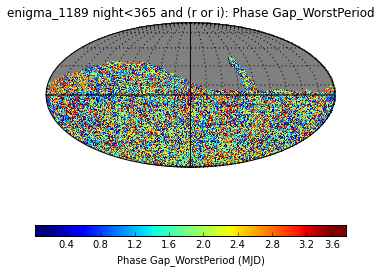

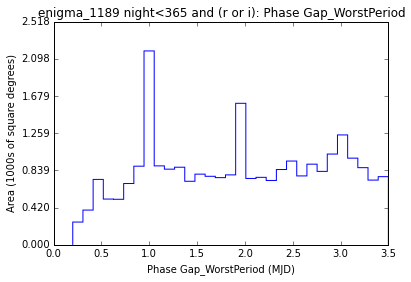

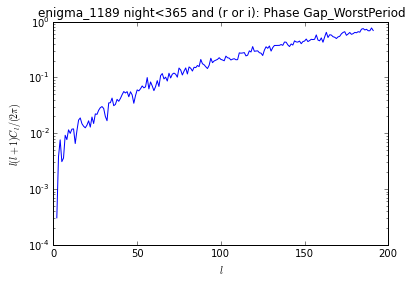

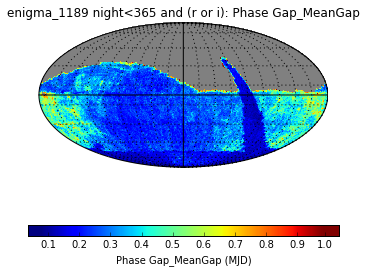

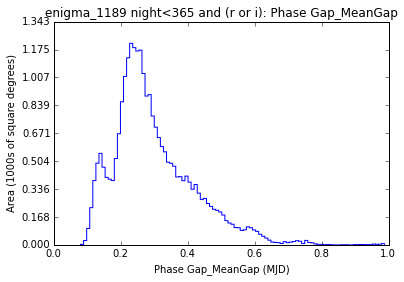

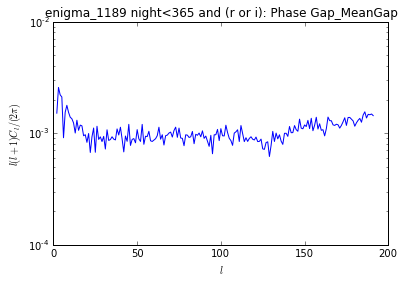

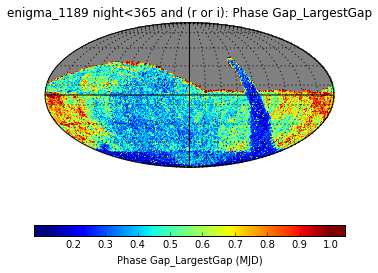

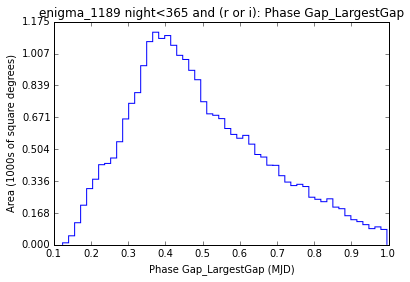

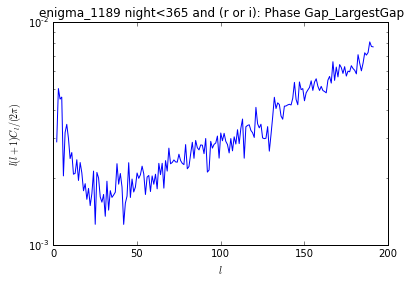

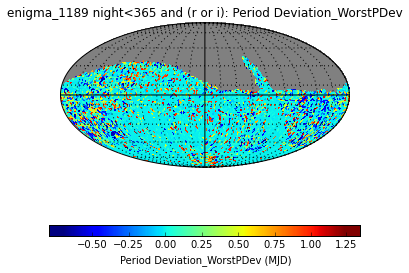

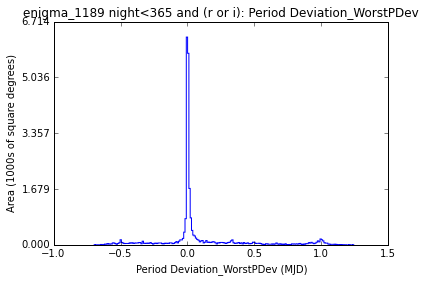

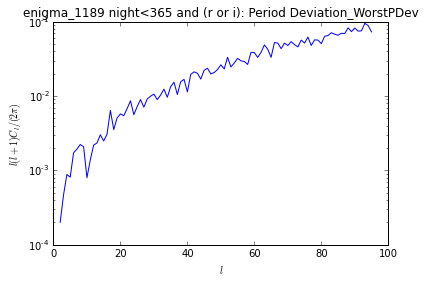

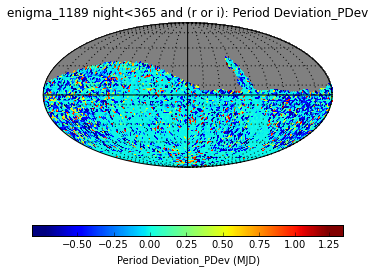

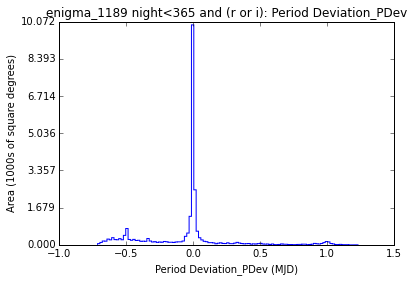

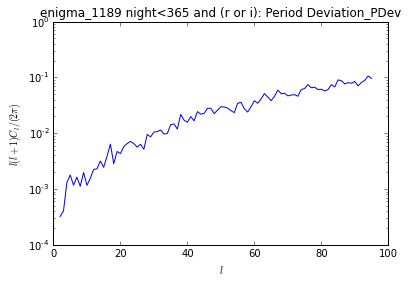

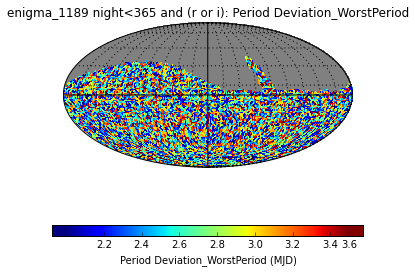

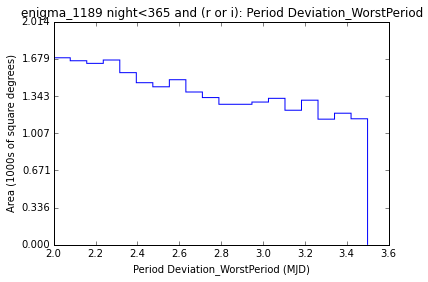

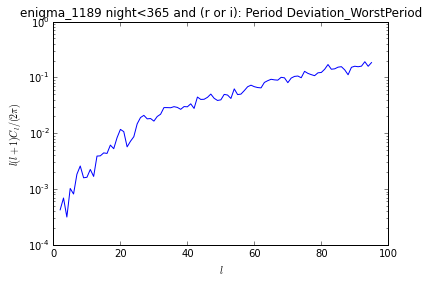

In [9]:
bgroup.plotAll(closefigs=False)

Plot a contour plot of the periods vs. phase gaps (counting all points across the sky). 
(We'll add this kind of plot as a plotter option into maf itself, but it just hasn't quite made it there yet.)

In [10]:
def count_number(x, y, xbinsize=None, ybinsize=None, nxbins=None, nybins=None):
    # Set up grid for contour/density plot.
    xmin = min(x)
    ymin = min(y)
    if (xbinsize!=None) & (ybinsize!=None):
        xbins = np.arange(xmin, max(x), xbinsize)
        ybins = np.arange(ymin, max(y), ybinsize)
        nxbins = xbins.shape[0]
        nybins = ybins.shape[0]
    elif (nxbins!=None) & (nybins!=None):
        xbinsize = (max(x) - xmin)/float(nxbins)
        ybinsize = (max(y) - ymin)/float(nybins)
        xbins = np.arange(xmin, max(x), xbinsize)
        ybins = np.arange(ymin, max(y), ybinsize)
        nxbins = xbins.shape[0]
        nybins = ybins.shape[0]
    else:
        raise Exception("Must specify both of either xbinsize/ybinsize or nxbins/nybins")
    counts = np.zeros((nybins, nxbins), dtype='int')
    # Assign each data point (x/y) to a bin.
    for i in range(len(x)):
        xidx = min(int((x[i] - xmin)/xbinsize), nxbins-1)
        yidx = min(int((y[i] - ymin)/ybinsize), nybins-1)
        counts[yidx][xidx] += 1
    # Create 2D x/y arrays, to match 2D counts array.
    xi, yi = np.meshgrid(xbins, ybins)
    return xi, yi, counts

/Users/lynnej/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10


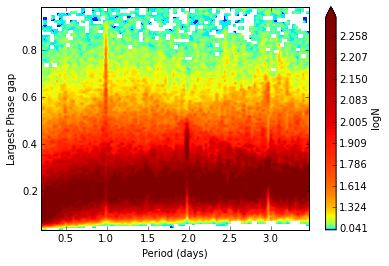

In [15]:
nperiods = len(phaseBundle.metricValues[-1:][0]['periods'])
periods = []
phaseGaps = []
for mval in phaseBundle.metricValues.compressed():
    for p, pGap in zip(mval['periods'], mval['maxGaps']):
            periods.append(p)
            phaseGaps.append(pGap)

periods = np.array(periods, 'float')
phaseGaps = np.array(phaseGaps, 'float')
timeGaps = phaseGaps * periods

periodi, phasegapi, counts = count_number(periods, phaseGaps, nxbins=100, nybins=100)
plt.figure()
levels = np.log10(np.arange(0.1, 200, 1))
plt.contourf(periodi, phasegapi, np.log10(counts), levels, extend='max')
cbar = plt.colorbar()
cbar.set_label('logN')
plt.xlabel('Period (days)')
plt.ylabel('Largest Phase gap')

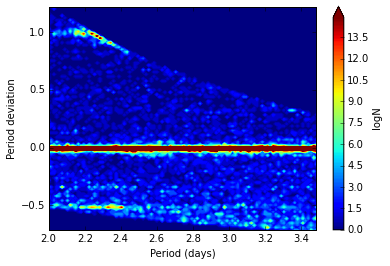

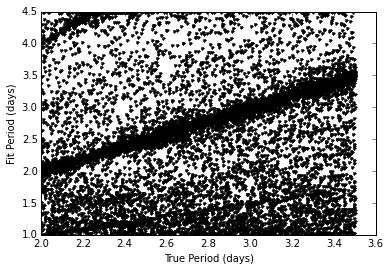

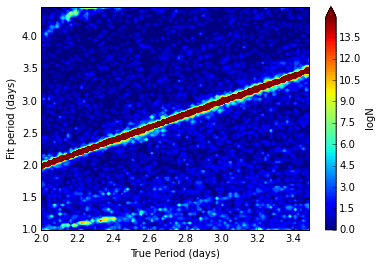

In [25]:
nperiods = len(periodBundle.metricValues[-1:][0]['periods'])
periods = []
periodsdev = []
for mval in periodBundle.metricValues.compressed():
    for p, pdev in zip(mval['periods'], mval['periodsdev']):
            periods.append(p)
            periodsdev.append(pdev)

periods = np.array(periods, 'float')
periodsdev = np.array(periodsdev, 'float')
fitperiods = periodsdev * periods + periods

periodi, periodsdevi, counts = count_number(periods, periodsdev, nxbins=100, nybins=100)
plt.figure()
levels = np.arange(0, 15, .1)
#levels = np.log10(levels)
#counts = np.log10(counts)
plt.contourf(periodi, periodsdevi, counts, levels, extend='max')
cbar = plt.colorbar()
cbar.set_label('logN')
plt.xlabel('Period (days)')
plt.ylabel('Period deviation')


plt.figure()
plt.plot(periods, fitperiods, 'k.')
plt.xlabel('True Period (days)')
plt.ylabel('Fit Period (days)')

periodi, fitperiodsi, counts = count_number(periods, fitperiods, nxbins=100, nybins=100)
plt.figure()
#counts = np.log10(counts)
plt.contourf(periodi, fitperiodsi, counts, levels, extend='max')
cbar = plt.colorbar()
cbar.set_label('logN')
plt.xlabel('True Period (days)')
plt.ylabel('Fit period (days)')